# Sentiment Analysis

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy

# Sklearn
from sklearn.model_selection import train_test_split


# Built-in library
import re
import warnings
import itertools

warnings.filterwarnings("ignore")

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
# !wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

In [3]:
def load_data(
    *, filename: str, sep: str = ",", encoding: str = "utf-8"
) -> pd.DataFrame:
    """This is used to load the data.
    Params;
        filename (str): The filepath.
        sep (str, default=","): The separator. e.g ",", "\t", etc
        encoding (str, default="utf-8): The encoding type.

    Returns:
        data (pd.DataFrame): The loaded dataframe.
    """
    data = pd.read_csv(filename, sep=sep, encoding=encoding)
    print(f"Shape of data: {data.shape}\n")
    return data

In [4]:
# Load data
fp = "AirlineTweets.csv"
data = load_data(filename=fp)

data.head()

Shape of data: (14640, 15)



,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data["airline_sentiment"].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [6]:
# Select the relevant features
df = data.copy()

features = ["text", "airline_sentiment"]
df = df[features]
mapper = {"positive": 2, "negative": 0, "neutral": 1}
df["airline_sentiment"] = df["airline_sentiment"].map(mapper)


df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,2
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
4,@VirginAmerica and it's a really big bad thing about it,0


In [7]:
# Split the data
RANDOM_STATE = 123
TEST_SIZE = 0.2

X = df["text"]
y = df["airline_sentiment"]

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

((11712,), (2928,))

In [8]:
# Vectorize the data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression


tfidf = TfidfVectorizer(max_features=3_000)
X_train_vec = tfidf.fit_transform(X_train)
X_validation_vec = tfidf.transform(X_validation)

In [9]:
# Init
log_model = LogisticRegression(max_iter=500)

# Fit
log_model.fit(X_train_vec, y_train)

# Make Predictions
y_pred_train = log_model.predict(X_train_vec)
y_pred_validation = log_model.predict(X_validation_vec)

# [0, 1, 2] where positive: 2
# Select the probability of belonging to the positive class
y_proba_train = log_model.predict_proba(X_train_vec)
y_proba_validation = log_model.predict_proba(X_validation_vec)

In [10]:
y_pred_train[:5], y_proba_train[:5, 2]

(array([0, 0, 0, 1, 0]),
 array([0.0805044 , 0.09946245, 0.03214944, 0.20682177, 0.02035309]))

In [11]:
y_proba_train.shape

(11712, 3)

In [12]:
from sklearn import metrics

# Calculate AUC
roc_auc_train = metrics.roc_auc_score(
    y_true=y_train, y_score=y_proba_train, multi_class="ovo"
)
roc_auc_validation = metrics.roc_auc_score(
    y_true=y_validation, y_score=y_proba_validation, multi_class="ovo"
)

roc_auc_train, roc_auc_validation

(0.9461007084922629, 0.9106345653680602)

In [13]:
pd.Series(y_train).value_counts(normalize=True)

0    0.626622
1    0.210126
2    0.163251
Name: airline_sentiment, dtype: float64

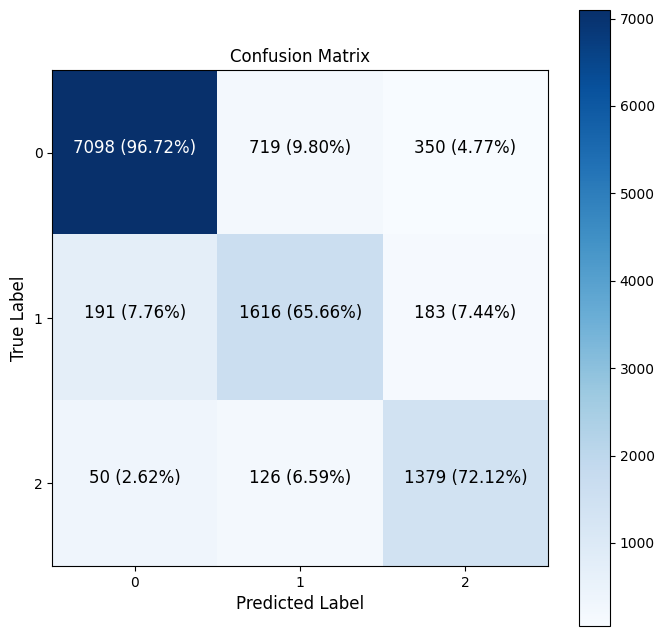

In [14]:
from src.metrics import plot_confusion_matrix

plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train, figsize=(8, 8))

In [15]:
pd.Series(y_validation).value_counts(normalize=True)

0    0.628074
1    0.217896
2    0.154030
Name: airline_sentiment, dtype: float64

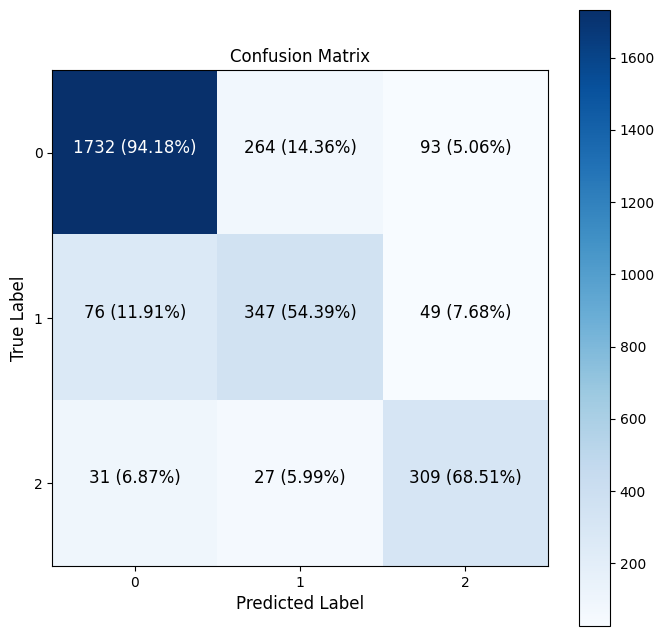

In [16]:
plot_confusion_matrix(y_true=y_validation, y_pred=y_pred_validation, figsize=(8, 8))

## Binary Case

* Consider only the `Positive` and `Negative` tweets.

In [17]:
df_1 = data.copy()

labels = ["positive", "negative"]
features = ["text", "airline_sentiment"]

df_1 = df_1[features]

df_1 = df_1.loc[df_1["airline_sentiment"].isin(labels)]
df_1.head()

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive


In [18]:
mapper = {"positive": 1, "negative": 0}
df_1["airline_sentiment"] = df_1["airline_sentiment"].map(mapper)
df_1.head(3)

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials to the experience... tacky.,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
4,@VirginAmerica and it's a really big bad thing about it,0


In [19]:
X = df_1["text"]
y = df_1["airline_sentiment"]

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

((9232,), (2309,))

In [20]:
tfidf = TfidfVectorizer(max_features=3_000)
X_train_vec = tfidf.fit_transform(X_train)
X_validation_vec = tfidf.transform(X_validation)

In [21]:
# Init
log_model = LogisticRegression(max_iter=500)

# Fit
log_model.fit(X_train_vec, y_train)

# Make Predictions
y_pred_train = log_model.predict(X_train_vec)
y_pred_validation = log_model.predict(X_validation_vec)

# [0, 1, 2] where positive: 2
# Select the probability of belonging to the positive class
y_proba_train = log_model.predict_proba(X_train_vec)[:, 1]
y_proba_validation = log_model.predict_proba(X_validation_vec)[:, 1]

In [22]:
# Calculate AUC
roc_auc_train = metrics.roc_auc_score(y_true=y_train, y_score=y_proba_train)
roc_auc_validation = metrics.roc_auc_score(
    y_true=y_validation, y_score=y_proba_validation
)

# It has better AUC Scores
roc_auc_train, roc_auc_validation

(0.9799090063790995, 0.9582555022697968)

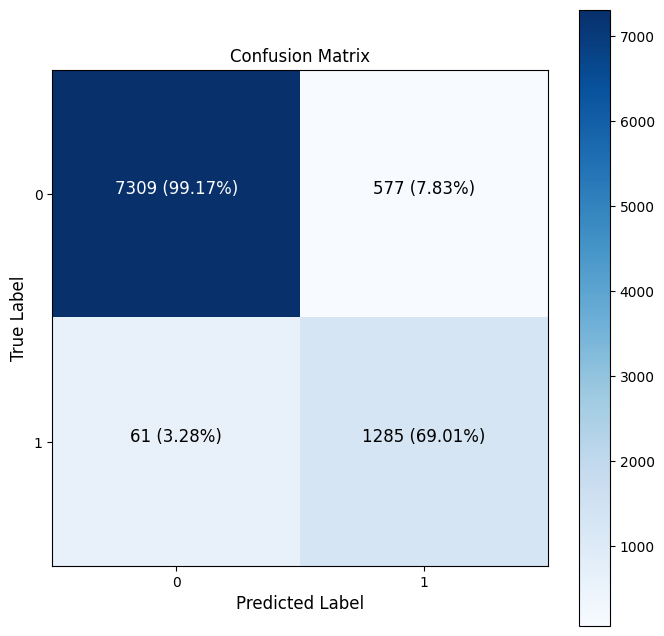

In [23]:
plot_confusion_matrix(y_true=y_train, y_pred=y_pred_train, figsize=(8, 8))

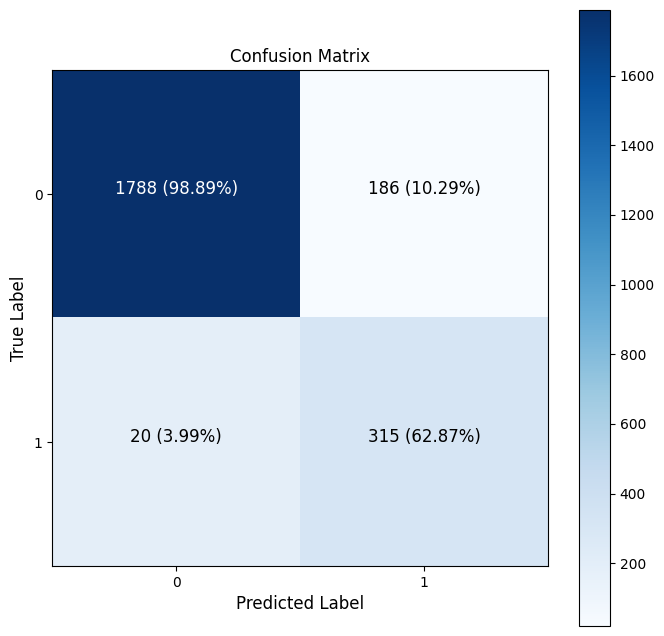

In [24]:
plot_confusion_matrix(y_true=y_validation, y_pred=y_pred_validation, figsize=(8, 8))

In [25]:
# Get the vocabulary used to train the model
vocab = tfidf.vocabulary_
dict(itertools.islice(vocab.items(), 0, 5))

{'usairways': 2815, 'with': 2933, 'the': 2632, 'weather': 2888, 'mess': 1716}

In [26]:
# The number of tokens
len(vocab)

3000

In [27]:
# Model Coefficients
# Each cofficient represents the weight of the tokens in the vocabulary
log_model.coef_, log_model.coef_.shape

(array([[-0.29778512,  0.555137  , -0.09157558, ...,  0.12125814,
         -0.46384988, -0.1848618 ]]),
 (1, 3000))

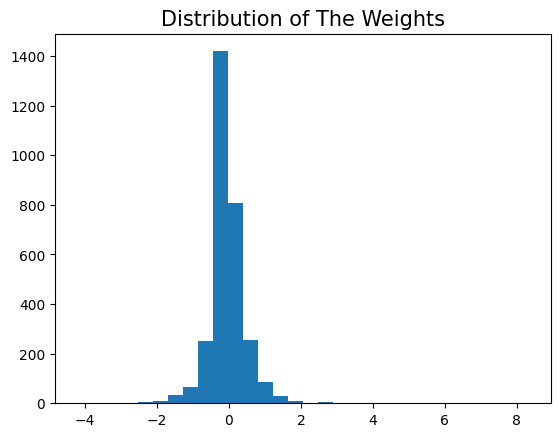

In [28]:
plt.hist(log_model.coef_[0], bins=30)
plt.title("Distribution of The Weights", size=15)
plt.show()

In [29]:
# Extract the weight of each token/word
# Print the Positive tokens
THRESH = 2

for word, idx in vocab.items():
    weight = log_model.coef_[0][idx]
    if weight > THRESH:
        print(f"{word}: {weight}\n")

thanks: 8.31737869386058

great: 5.447121649849935

good: 3.23969177224339

southwestair: 2.8333021178085804

jetblue: 3.2121831342480514

best: 3.818356337657815

virginamerica: 3.3475615853089744

thank: 7.965185387900743

nice: 2.25786668078232

awesome: 4.134092433735932

love: 4.410541297570322

amazing: 3.708801021036919

worries: 2.540982374559471

excellent: 2.087132469275032

kudos: 2.655112295430212

appreciate: 2.8430563860487528

thx: 2.8320139134183484

wonderful: 2.320571065351445



In [30]:
# Extract the weight of each token/word
# Print the Negative tokens

for word, idx in vocab.items():
    weight = log_model.coef_[0][idx]
    if weight < -THRESH:
        print(f"{word}: {weight}\n")

not: -4.210005177228261

cancelled: -2.6586937135532107

nothing: -2.3134136928313382

can: -2.1048093093173015

no: -3.63913378564003

what: -2.2851949369959623

don: -2.2047381130112393

hold: -2.931078459331323

hour: -2.1743305510816766

delayed: -2.9644622204993953

hours: -3.268603422398673

why: -2.238175008036301

worst: -3.2519458367436416

website: -2.1383220865086714

call: -2.0530987448070763



In [31]:
# Check the wrongly classified messages
temp = pd.concat([X_train, y_train], axis=1).copy()

temp["pred"] = y_pred_train
wrong_pred = temp.loc[((temp["airline_sentiment"] == 1) & (temp["pred"] == 0))]
wrong_pred.head()

,text,airline_sentiment,pred
11685,"@USAirways with the weather mess in the South, I missed my connection in CLT. Impressed though with the Cust Serv phone reps today.",1,0
11998,"@americanair new plane, #gogo, easy power for laptop, iPhone, just missing a good boat-style swivel cup holder for my #dietcoke #happyflier",1,0
11458,@USAirways thanks for reaching out to me. My Gold Div no. 2k424j0. My Flights were changed under Confirmation # DNX58V.,1,0
9240,@USAirways @AmericanAir Can you bring guinea pigs in small pet carrier onboard your flights?,1,0
1452,@united I have 8 flights with you in the next two weeks :) let's make some good memories!,1,0


In [32]:
# Check the wrongly classified messages
temp = pd.concat([X_train, y_train], axis=1).copy()

temp["pred"] = y_pred_train
wrong_pred = temp.loc[((temp["airline_sentiment"] == 0) & (temp["pred"] == 1))]
wrong_pred.head()

,text,airline_sentiment,pred
7292,@JetBlue thank you! Hopefully it's soon! We are supposed to leave at 11:23,0,1
4815,".@SouthwestAir glad you appreciate it, it’ll be the last dollar you ever get from me thanks to your wretched customer service",0,1
4295,@united's first-class #cockup\nhttp://t.co/oh7CFv7DHR,0,1
7540,@JetBlue Thanks for the THIRD gate change http://t.co/UfBdr5AxeO,0,1
7164,Haha! @JetBlue: Our fleet's on fleek. http://t.co/KmaNLdQbh4”,0,1


## To Do

* Clean and tokenize the tweets to see if it improves the model performance.